# 모델 생성
- 앞에 선택한 데이터들을 이용하여 전력량을 예측하는 모델을 생성
- 독립변수 : 지역코드, 최저기온(°C), 3.0m 지중온도(°C), 평균 현지기압(hPa), 가조시간(hr), 평균 상대습도(%), 풍정합(100m), 합계 소형증발량(mm)
- 타겟변수 : 파워 (전력량)

In [1]:
import tensorflow as tf
print("텐서플로우 버전:", tf.__version__)

from tensorflow.keras.layers import Dense, Dropout, Input
print("Keras 임포트 성공!")

텐서플로우 버전: 2.10.0
Keras 임포트 성공!


## 모델 생성을 위한 훈련데이터

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('../data/훈련데이터셋/1_훈련데이터셋_날짜포함.csv')
df.head(1)

,지역코드,날짜,최저기온(°C),0.5m 지중온도(°C),평균 증기압(hPa),가조시간(hr),평균 상대습도(%),파워
0,1111010100,2022-12-04,-5.2,7.5,1.8,9.7,38.9,146294.6135


In [4]:
# 날짜 처리 & 독립변수 생성
df['날짜'] = pd.to_datetime(df['날짜'])
df['month'] = df['날짜'].dt.month
df['day'] = df['날짜'].dt.day
df['weekday'] = df['날짜'].dt.weekday

### 데이터셋을 train, test로 나누기

In [5]:
X = df.drop(columns=['파워','날짜'])
y = df['파워']
X.shape, y.shape

((181408, 9), (181408,))

In [6]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((145126, 9), (36282, 9), (145126,), (36282,))

### 훈련데이터 전처리
- 지역코드는 순서 개념이 없는 범주형 변수이므로 수치적 크기 왜곡을 방지하기 위해 원-핫 인코딩으로 처리하였다.

- 기상 변수 및 파생 변수는 서로 다른 단위를 가지므로 모델 학습 안정성과 수렴 속도를 개선하기 위해 표준화(Standardization)를 적용하였다.

- 전처리 과정에서 데이터 누수를 방지하고, 학습·검증·테스트 데이터에 동일한 변환 규칙을 일관되게 적용하기 위해 ColumnTransformer 기반 전처리 파이프라인을 구성하였다.

행 당 한개의 정규화 모델을 만들기에는 너무 많은 정규화 모델이 만들어지고 이를 하나하나 다 저장하기에는 힘들기에 sklear의 ColumnTransformer를 사용

In [7]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = ['지역코드']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False
        ), cat_cols),
        ('scaler', StandardScaler(), num_cols)
    ]
)

In [8]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [9]:
# 전처리 모델 저장하기
import joblib
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

## 모델 생성 (DNN)

### 간단한 모델
- 간단한 모델 하나를 만들어 훈련시간과 결과를 보기

In [10]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
X_train_preprocessed.shape, y_train.shape

((145126, 475), (145126,))

In [13]:
model = Sequential()
model.add(Input(X_train_preprocessed.shape[1],))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               243712    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [15]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

path = 'SimpleDNN/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit(
    X_train_preprocessed,   
    y_train,
    callbacks=[earlyStop, checkpoint],
    validation_split=0.2,
    epochs=100,
    verbose=1
)

Epoch 1/100
3629/3629 [==============================] - 13s 3ms/step - loss: 49116631040.0000 - mae: 53983.1719 - mse: 49116631040.0000 - val_loss: 46064046080.0000 - val_mae: 37469.9570 - val_mse: 46064046080.0000
Epoch 2/100
3629/3629 [==============================] - 12s 3ms/step - loss: 35095179264.0000 - mae: 35789.6367 - mse: 35095179264.0000 - val_loss: 44247851008.0000 - val_mae: 38277.5625 - val_mse: 44247851008.0000
Epoch 3/100
3629/3629 [==============================] - 12s 3ms/step - loss: 33948733440.0000 - mae: 34171.6953 - mse: 33948733440.0000 - val_loss: 43191795712.0000 - val_mae: 31532.0684 - val_mse: 43191795712.0000
Epoch 4/100
3629/3629 [==============================] - 12s 3ms/step - loss: 33455738880.0000 - mae: 34325.0273 - mse: 33455738880.0000 - val_loss: 40230326272.0000 - val_mae: 34626.3516 - val_mse: 40230326272.0000
Epoch 5/100
3629/3629 [==============================] - 12s 3ms/step - loss: 33205463040.0000 - mae: 33087.2500 - mse: 33205463040.0000

In [18]:
# 테스트 해보기
X_test_preprocessor = preprocessor.transform(X_test)
test_loss, test_mae, test_mse = model.evaluate(X_test_preprocessor, y_test, verbose=0)
print(f"\nTest Results:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")


Test Results:
  MSE: 33408565248.00
  MAE: 30274.18
  RMSE: 182780.10


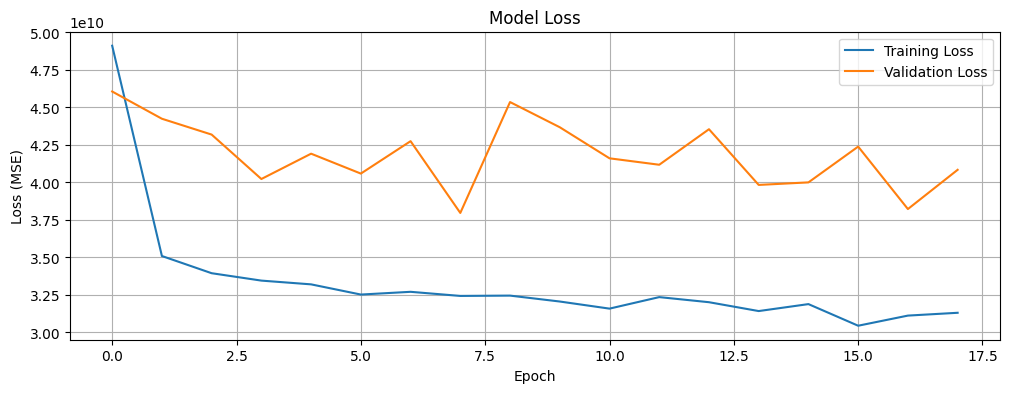

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)